# **Linear Algebra for Data Science**: HW3, task 2  
# *Point cloud registration. Procrustes problem* (3 pts)
### <div align="right"> &copy; Ostap Viniavskyi & Rostyslav Hryniv, 2023 </div>

## Completed by:   
*   First team member
*   Second team member

The aim of this task is find a rigid transformation that aligns two 3D objects (point clouds) in the best possible way. In the case when point pairs to be matched are given, this is known as Procrustes problem and can be solved via SVD. Otherwise, we will use the Iterative Closest Point (ICP) method that, in most cases, results in good alignment in several iterations

#1. Introduction

A **point cloud** is a discrete set of data points in space. [Wiki](https://en.wikipedia.org/wiki/Point_cloud) \
In this homework we will work with 3D point clouds representing a 3D shape or object. Each point is associated with its Cartesian coordinate $(X, Y, Z)$ in space and potentially some additional information, like RGB color, even though we would not use any here. Usually, 3D point cloud are obtained from LIDAR scans or from the 3D reconstuction from multiple views of the same scene or object.

**Point cloud registration** is the problem of finding a spatial transformation (translation, rotation, scaling, etc.) that aligns two point sets. [Wiki](https://en.wikipedia.org/wiki/Point-set_registration)

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Cpd_fish_affine.gif" width="300"/>
</div>

In this homework we will work with the case of the **rigid transformation in the 3D space**, meaning that the point clouds in question represent the same 3D rigid body in different positions in space.

**Rigid-body motion in the 3D space** is represented by the 3x3 rotation matrix $R$ and 3D translation vector $T$. Rotation matrix $R$ belongs to the group of Special-Orthogonal Transformations $SO(3)$ - the group of orthogonal matrices with determinant equalt to $1$. (*Note: Orthogonal matrices whose determinant is equal to $-1$ represent such transformation in space that incorporates both rotation and reflection, the latter of which is not a valid transformation in 3D.*) More on 3D rotation representations and rigid body motion in general can be learnt from this amazing [lecture from the TUM](https://youtu.be/khLM8VV8LuM?list=PLTBdjV_4f-EJn6udZ34tht9EVIW7lbeo4).

Moving to the problem in question, imagine that you have to program an algorithm for a robot to move objects from one point in 3D space to some target position. The robot has the ability to scan the environment around it and obtain the point cloud of the objects. Also, it is provided with some idealized model of the object already in the target position. The main challenge is to find how the scan of real object corresponds to its idealized model and find rigid transformation that provides best alignment.

In the **data** directory you are provided with:
- `bottle_scan/*` -- the scanned water bottle textured mesh from which you can easily extract its point cloud
- `bottle-model.obj` -- the idealized water bottle mesh
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location
- `bottle-model-samples-10k-target.obj` -- same 10k points as in previous file but in the target location
- `bottle-model-samples-8k.obj` -- another 8k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location

You can use any 3D viewer to explore the meshes in depth. We recommend using [MeshLab](https://www.meshlab.net/#download) - an open-source tool for 3D objects display and manipulation.

From left to right: photo of the water bottle, scanned water bottle mesh with textures, point cloud of scanned water object, mesh of idealized bottle model, point cloud sampled on the surface of idealized model

<table>
  <tr>
    <th>
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1Mwi8Jtk6z0odkKqLfz1IB2C0IUBwq4gk" height="500" width="200"/>
      </div>
    </th>
    <th>
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1ak8HlcPLNJw2SKjgij4mxTHhQa_Pv8Ap" height="500" width="200"/>
      </div>
    </th>
    <th>
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1KFfoq0EaCViPPP6ad_aIE_dDiN-LHaX4" height="450" width="250"/>
      </div>
    </th>
    <th>
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1xyQRBZpAZky8BFihISwa-kxHSfbLFknK" height="450" width="200"/>
      </div>
    </th>
    <th>
      <div>
      <img src="https://drive.google.com/uc?export=view&id=1fY37CHOC976dxn6KvOxIenv1l6nlZsli" height="350" width="200"/>
      </div>
    </th>
  </tr>
</table>

Already, you can see that the idealized model is not exactly the same as the scanned point cloud, and even the number of points is very different. Nevertheless, by carefully step-by-step designing our registration algorithm through the course of this and the next homework on optimization, we will try to align these two point clouds and find good-enough rigid transformation.

Among other problems with point-cloud registration can be:
- partial occlusions;
- outlying points;
- scale differences.

Yet, for simplicity we do not try to solve such cases in this homework. Indeed, classical methods are not very good at aligning partially occluded point clouds, thus Deep Learning methods come to help here.

In [1]:
! pip install numpy matplotlib trimesh scipy tqdm

                                              0.0/689.0 kB ? eta -:--:--
     -                                     20.5/689.0 kB 217.9 kB/s eta 0:00:04
     ----                                  92.2/689.0 kB 871.5 kB/s eta 0:00:01
     ---------------------                  389.1/689.0 kB 2.7 MB/s eta 0:00:01
     -------------------------------------- 689.0/689.0 kB 3.9 MB/s eta 0:00:00


# **Task 1 (1 pts)**: The case of known correspondences.

We start with the simpler task of aligning two point cloud with known correspondences. They differ only by some unknown rigid-body transformation $R$ and $T$ that you have to find. The problem is known as Orthogonal procrustes problem as it requires finding an orthogonal 3D rotation matrix $R$.

For this task we will use point cloud of an idealized model of the water bottle in two different positions in space. The points are sampled on the surface of the model once, and rotated/translated with some true $R$ and $T$ that you have to find. Thus we know exactly the correspondences between 10 thousand points in source and target point clouds.

Here we will be working with the following two files:
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the source location
- `bottle-model-samples-10k-target.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the target location

In [11]:
from typing import Tuple, List

from scipy.spatial import KDTree
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial.transform import Rotation
from tqdm import tqdm

In [4]:
# read points in the source and target positions
def read_obj(fname: str) -> np.ndarray:
    """Read .obj file containing point cloud using trimesh library."""
    with open(fname) as f:
        data = trimesh.exchange.obj.load_obj(f)
    return data['vertices']

src_fname = 'data/bottle-model-samples-10k.obj'
trg_fname = 'data/bottle-model-samples-10k-target.obj'

pts_src = read_obj(src_fname)
pts_trg = read_obj(trg_fname)
pts_src.shape, pts_trg.shape

((10000, 3), (10000, 3))

Given two sets of corresponding points $x_i \leftrightarrow y_i, i \in {1\dots M}, y_i \in \mathbb{R}^3, x_i \in \mathbb{R}^3$ we know that the points locations are related by the following equations:
$$y_i = Rx_i + T$$
Stacking all points into two $3\times M$matrices $X$ and $Y$, we can write the equations simultaneously for all points:
$$Y = RX + T_{broadcasted}$$
where $T_{broadcasted}$ is also $3\times M$ matrix of column vector $T$ horizontally stacked $M$ times

In general, we assume that there is some noise present and try to find $R$ and $T$, such that the mean-squared error is minimized:
$$R, T = \mbox{arg}\min_{R', T'} \sum_i ||y_i - R'x_i + T'||^2$$

First, we can eliminate $T$ from the minimization problem and solve only for $R$. For this reason we normalize point clouds $X$ and $Y$ by subtracting their centroids $\overline{x}$ and $\overline{y}$  from each points in $X$ and $Y$ respectively.
Let's denote the resulting matrices $\hat{X}$ and $\hat{Y}$.





##**Task 1.1 (0.2 pts)**
Show that $\hat{Y} = R\hat{X}$.

---
#### **YOUR DERIVATION HERE**

---

Once we eliminated $T$, we only look for orthogonal $R$ (actually, special orthogonal R, but it doesn't matter to us now, since we know that true transformation is valid rotation). The problem becomes:
$$R = \mbox{arg}\min_{R'} \sum_i||\hat{y_i} - R'\hat{x_i}||^2 = \mbox{arg}\min_{R'} ||R'\hat{X_i} - \hat{Y_i}||^2_F$$

---
##**Task 1.2 (0.4 pts)**
Prove that the $R$ that minimizes the above error function is $R = UV^T$, where $XY^T = U\Sigma V^T$ is SVD of $3\times 3$ matrix $YX^T$

---
#### **YOUR DERIVATION HERE**
---

Then $T$ can be recovered as $T = \overline{y} - R\overline{x}$



---
##**Task 1.3 (0.4 pts)**
Implement solution to the Orthogonal procrustes problem given two sets of points  X  and  Y . You can rely on the numpy SVD solver.

In [9]:
def orthogonal_procrustes(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implementation of Orthogonal procrustes problem
    Args:
        X: 3D points from the first point cloud; shape: (3, M)
        Y: 3D points from the second point cloud; shape: (3, M)

    Returns:
        R: rotation matrix; shape: (3, 3)
        T: translation vector; shape: (3, )
    """
    # =========== YOUR CODE STARTS HERE ============
    U, _, V = np.linalg.svd((X - np.mean(X, axis=1, keepdims=True)) @ (Y - np.mean(Y, axis=1, keepdims=True)).T)
    R = V.T @ U.T
    T = -R @ np.mean(X, axis=1, keepdims=True) + np.mean(Y, axis=1, keepdims=True)
    T = np.squeeze(T)
    # =========== YOUR CODE ENDS HERE ==============
    return R, T

R_pred, T_pred = orthogonal_procrustes(X=pts_src.T, Y=pts_trg.T)
r_euler = Rotation.from_matrix(R_pred).as_euler('xyz', degrees=True)
print(f'Predicted rotation: X={r_euler[0]:.3}deg, Y={r_euler[1]:.3}deg, Z={r_euler[2]:.3}deg')
print(f'Predicted translation: X={T_pred[0]:.3}m, Y={T_pred[1]:.3}m, Z={T_pred[2]:.3}m')


Predicted rotation: X=20.0deg, Y=30.0deg, Z=40.0deg
Predicted translation: X=-0.2m, Y=0.3m, Z=-0.4m


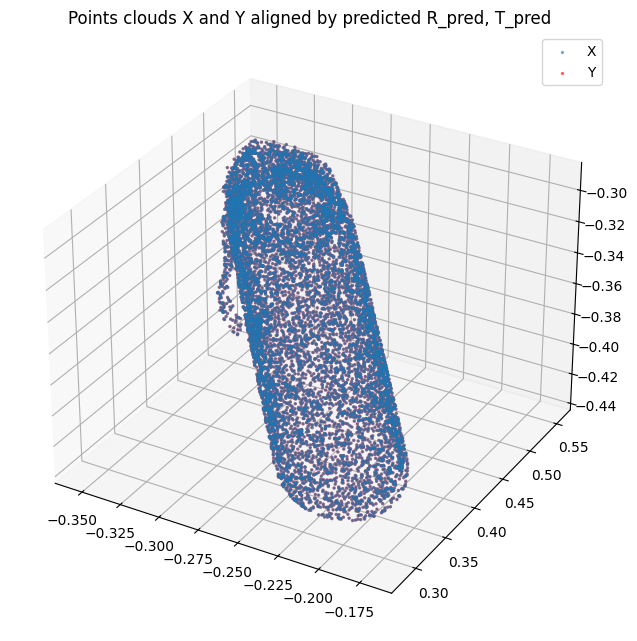

In [10]:
# plot predictions X - in blue, Y - in read
def plot_predictions(X, Y, R, T):

    X = X @ R.T + T

    fig = plt.figure(figsize=(17, 17))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2., alpha=0.5)

    # ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='r', s=2., alpha=0.5)
    plt.legend(['X', 'Y'])

    plt.title('Points clouds X and Y aligned by predicted R_pred, T_pred')

    plt.show()

plot_predictions(pts_src, pts_trg, R_pred, T_pred)

# **Task 2 (2 pts)**: Case of unknown correspondences.

In this task we will continue to work with model of water bottle. In contrast to the previous problem we will not assume known correspondences, nor equal number of points in source and target point clouds. To simulate this scenario we will sample points on the surface of mesh twice: once 10k points and once 8k points. We will assume some manually specified rigid transformation on the second points cloud and explore how it affects the results of the algorithm.


Here we will be working with the following two files:
- `bottle-model-samples-10k.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location
- `bottle-model-samples-8k.obj` -- 8k points sampled uniformly on the surface of `bottle-model.obj` mesh in the initial location

Next we will use **Iterative Closest Points (ICP)** algorithm to iteratively find the optimal rigid motion. The algorithm switches between 2 steps:
- finding matching between two sets --> for each $x_i$ in $X$ we find $y_{n_i}$ in the set $Y$ such that $||Rx_i + T - y_{n_i}||^2$ is minimal among all $y_j, j \in 1\dots N$ for current rotation estimate $R$ and translation estimate $T$.
- solving orthogonal Procrustes problem for the established correspondences to update $R$ and $T$.

We can define the point-to-point error measure in terms of Mean Squared Error between matched points.
$MSE(R, T) = \frac{1}{n} \sum_i ||Rx_i + T - y_{n_i}||^2$, where $y_{n_i}$ is the correspondence of $x_i$ as defined above.
Note that each point in $Y$ can be matched with multiple points in $X$.

Repeating those steps, until the error decreases in one iteration less than some threshold $\tau$, will allow us to monotonically decrease the error on each step and converge to a solution. However, the solution is not guaranteed to be the optimal one as the algorithm **may get stuck in the local minima**.



---
##**Task 2.1 (0.8 pts)**
Prove that MSE is guaranteed to monotonically decrease or stay the same on each step of ICP.

---
#### **YOUR PROOF HERE**

---


---
##**Task 2.2 (1.2 pts)**
Implement solution to the ICP given two sets of points $X$ and $Y$. You can rely on your previous Orthogonal procrustes solver.
Test your solution like the following:
1. Generate ground truth rotations $R_{gt}$ around X-axis with the angles from $0^\circ$ to $355^\circ$ with the step $10^\circ$ and apply it along with provided translation $T_{gt}$ to the `bottle-model-samples-8k.obj` point cloud. You can use scipy rotation representations convertor to obtain rotation matrix from axis-angle representation.
2. Try to estimate the rotation and translation between `bottle-model-samples-10k.obj` and transformed `bottle-model-samples-8k.obj` using your ICP implementation.
3. Calculate rotation and translation error for each ground truth rotation angle and plot the graphs with angle on the x-axis and error in the y-axis. Code for error calculation will be provided to you. Also plot mse-loss histories and predicted points clouds for the angles of $60^\circ$ and $180^\circ$.
4. Comment on the result. Why the error is nearly 180 degrees after the true rotation exceeds 90 degrees?

- find_optimal_correspondences - 0.3 pts
- icp (optimization loop) - 0.3 pts
- testing on multiple ground truth rotation angles - 0.2 pts
- plots and comments - 0.4 pts


In [15]:
def find_optimal_correspondences(X: np.ndarray, Y: np.ndarray,
                                 R: np.ndarray, T: np.ndarray) -> Tuple[np.ndarray, float]:
    """
    Finds closest point from Y for each point in the point cloud X transformed by motion (R, T)
    Also compute mean square error between each transformed point in X and nearest neighbor in Y
    Args:
        X: 3D points from the first point cloud; shape: (3, M)
        Y: 3D points from the second point cloud; shape: (3, N)
        R: current rotation estimate
        T: current translation estimate

    Returns:
        Y_nn: nearest neighbors from Y for each point in transformed X; shape (3, M)
        J: mean square error
    """
    # =========== YOUR CODE STARTS HERE ============
    X_transformed = R @ X + T[:, np.newaxis]
    tree = KDTree(Y.T)
    distances, indices = tree.query(X_transformed.T)
    Y_nn = Y[:, indices]
    J = np.mean(distances**2)
    # =========== YOUR CODE ENDS HERE ==============
    return Y_nn, J

def icp(X: np.ndarray, Y: np.ndarray, tau: float = 1e-6) -> Tuple[np.ndarray, np.ndarray, List[float]]:
    """
    Implementation of ICP for registration of unmatched point cloud of potentially different sizes
    Args:
        X: 3D points from the first point cloud; shape: (3, M)
        Y: 3D points from the second point cloud; shape: (3, N)
        tau: error decrease threshold used as stopping criterion
    Returns:
        R: rotation matrix; shape: (3, 3)
        T: translation vector; shape: (3, ),
        loss_history: list of MSE value at each iteration
    """
    # init rotation with identity and rotation with the vector between center of point clouds
    R, T = np.eye(3), Y.mean(1) - X.mean(1)
    # compute initial correspondences
    Y_nn, J = find_optimal_correspondences(X, Y, R, T)
    loss_history = [J]
    # =========== YOUR CODE STARTS HERE ============
    while True:
        R_new, T_new = orthogonal_procrustes(X, Y_nn)
        Y_nn, J_new = find_optimal_correspondences(X, Y, R_new, T_new)
        loss_history.append(J_new)
        if np.abs(J - J_new) < tau:
            break
        R, T = R_new, T_new
        J = J_new
    # =========== YOUR CODE ENDS HERE ==============
    return R, T, loss_history

In [16]:
# error metrics
def rigid_motion_error(R_true: np.ndarray, R_pred: np.ndarray,
                       T_true: np.ndarray, T_pred: np.ndarray) -> Tuple[float, float]:
    """
    Calculate error in rigid body motion: rotation and translation separately.
    For rotation compute minimal angle that transforms one rotation into other.
    For translation simply compute distance between two vectors.
    Args:
        R_true: true rotation; shape: (3, 3)
        R_pred: predicted rotation; shape: (3, 3)
        T_true: true translation; shape: (3,)
        T_pred: predicted translation; shape: (3,)
    Returns:
        rot_err: error in rotation in angles
        trans_err: error in translation in meters (or any other units)
    """
    cos = (np.trace(np.dot(R_true.T, R_pred)) - 1) / 2
    cos = np.clip(cos, -1., 1.)  # numercial errors can make it out of bounds
    rot_err = np.rad2deg(np.abs(np.arccos(cos)))
    trans_err = np.linalg.norm(T_true - T_pred)
    return rot_err, trans_err

In [17]:
# experimets part
src_fname = 'data/bottle-model-samples-10k.obj'
trg_fname = 'data/bottle-model-samples-8k.obj'

pts_src = read_obj(src_fname)
pts_trg = read_obj(trg_fname)
print(pts_src.shape, pts_trg.shape)
# axis of rotation - X
axis = np.array([1., 0., 0.])
# ground  truth translation
T_gt = np.array([0.5, 0.6, 0.7])

# angles
angles = [i * 10 for i in range(36)]
rot_errors = []
trans_errors = []
loss_histories = []

# =========== YOUR CODE STARTS HERE ============
for angle in tqdm(angles):
    rot = Rotation.from_euler('x', angle, degrees=True).as_matrix()
    pts_trg_rotated = rot @ pts_trg.T + T_gt[:, np.newaxis]
    R_pred, T_pred, loss_history = icp(pts_src.T, pts_trg_rotated, tau=1e-6)
    rot_err, trans_err = rigid_motion_error(rot, R_pred, T_gt, T_pred)
    rot_errors.append(rot_err)
    trans_errors.append(trans_err)
    loss_histories.append(loss_history)
# =========== YOUR CODE ENDS HERE ==============

(10000, 3) (8000, 3)


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.93it/s]


# **Task 3 (0.3 pts)**: Test on the real world scan.

Here we will test our algorithm on the provided scan.

We will be working with the following two files:
- `bottle-scan/textured_output.obj` -- textured mesh of scanned object.
- `bottle-model-samples-10k-target.obj` -- 10k points sampled uniformly on the surface of `bottle-model.obj` mesh in the target location



##**Task 3.1 (0.3 pts)**
Test ICP algorithm on real world scan and idealized model as a target. Report the results numerically and visually. Comment on the results.

(19553, 3) (10000, 3)
Predicted rotation: X=7.41deg, Y=0.755deg, Z=10.1deg
Predicted translation: X=-0.235m, Y=0.257m, Z=-0.362m


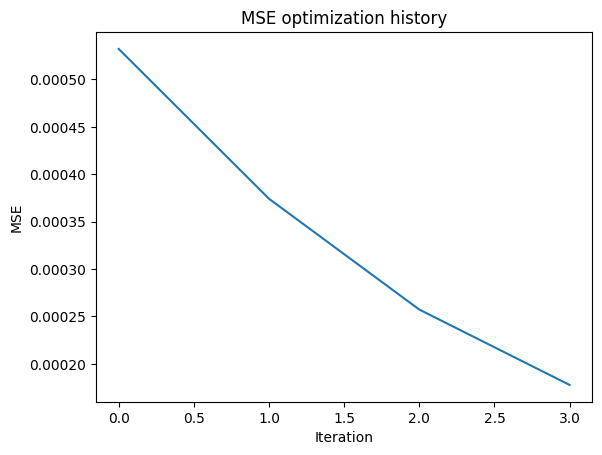

In [18]:
src_fname = 'data/bottle_scan/textured_output.obj'
trg_fname = 'data/bottle-model-samples-10k-target.obj'
pts_src = read_obj(src_fname)
pts_trg = read_obj(trg_fname)
print(pts_src.shape, pts_trg.shape)

# =========== YOUR CODE STARTS HERE ===========
R_pred, T_pred, loss_history = icp(X=pts_src.T, Y=pts_trg.T, tau=1e-4)
r_euler = Rotation.from_matrix(R_pred).as_euler('xyz', degrees=True)

print(f'Predicted rotation: X={r_euler[0]:.3}deg, Y={r_euler[1]:.3}deg, Z={r_euler[2]:.3}deg')
print(f'Predicted translation: X={T_pred[0]:.3}m, Y={T_pred[1]:.3}m, Z={T_pred[2]:.3}m')

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE optimization history');
# =========== YOUR CODE ENDS HERE ==============

# Conclusions (0.2 pts)
Comment on the work done in this homework and algorithms implemented. State their advantages and limitations.

---
**YOUR COMMENTS HERE**

---